In [1]:
# Get timings for each cell
%load_ext autotime

In [2]:
import os
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.stats import sigma_clip, sigma_clipped_stats

from ccdproc import ImageFileCollection, Combiner, CCDData

from scipy import fftpack
from scipy import stats

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.offsetbox as offsetbox
from matplotlib import pyplot as plt

plt.style.use('bmh')

from tqdm import tqdm  # Progress bars

from piaa.utils import helpers
from pong.utils import storage
from piaa.utils.plot import pixel_hist

time: 2.29 s


### Get the calibration images

Download the files from google storage buckets. 

In [3]:
# Get our calibration images for the unit
calibration_images = storage.get_observation_blobs('PAN001/calibration/')
len(calibration_images)

482

time: 306 ms


In [4]:
# Save FITS files to this location
local_save_dir = '/var/panoptes/images/flats'
os.makedirs(local_save_dir, exist_ok=True)

time: 1.19 ms


In [5]:
# !!!WARNING - Download from the google storage buckets - lots of data - WARNING!!!
file_list = list()
for fn in tqdm(calibration_images):
    local_fn = storage.download_fits_file(fn, save_dir=local_save_dir, unpack=False)
    file_list.append(local_fn)

100%|██████████| 482/482 [00:00<00:00, 34434.00it/s]

time: 18.3 ms


In [6]:
camera_id = 'ee04d1'

time: 929 µs


In [40]:
# Get the local path names
bias_list = [fn for fn in file_list if '{}_bias'.format(camera_id) in fn][0:100]

len(bias_list)

100

time: 4.31 ms


### Collect bias frames

We collect all the bias frames below and combine to form an average master bias.

In [41]:
# Build up a master bias data set
bias_data = []
for fname in tqdm(bias_list, total=len(bias_list)):
    with fits.open(fname) as hdul:
        hdu = hdul[1]
        meta = hdu.header
        meta['filename'] = fname
        bias_data.append(CCDData(data=hdu.data, meta=meta, unit="adu"))

100%|██████████| 100/100 [00:43<00:00,  2.31it/s]

time: 43.3 s


In [11]:
# Combine using average
biases = Combiner(bias_list)
master_bias = biases.average_combine()

time: 1min 34s


Read or write the master bias frame

In [8]:
master_bias_fn = '/var/panoptes/images/pan001-{}-master-bias.fits'.format(camera_id)

time: 1.03 ms


In [ ]:
# Write new master bias
master_bias.write(master_bias_fn, overwrite=True)

In [10]:
# Read existing master bias
master_bias = CCDData(data=fits.getdata(master_bias_fn).astype(np.float32), unit='adu')

time: 209 ms


#### Examine Master Bias

In [11]:
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

time: 1.18 ms


In [12]:
bias_min, bias_max, bias_mean, bias_std = imstats(np.asarray(master_bias))

time: 358 ms


In [13]:
bias_props = """Count:{:10d}
Min:  {:10.02f}
Max:  {:10.02f}
Mean: {:10.02f}
Std:  {:10.02f}""".format(
    len(master_bias.data.flatten()),
    bias_min, bias_max,
    bias_mean, bias_std,
)

time: 53.4 ms


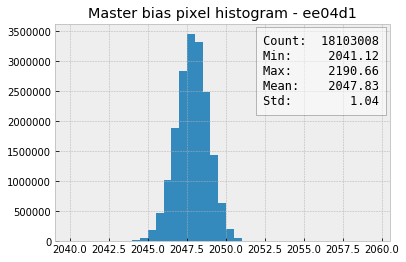

time: 1.46 s


In [14]:
# Histogram of pixels. 'step' type is ugly but way faster.
bins = plt.hist(master_bias.data.flatten(), 
                histtype='bar', 
                bins=np.arange(2040, 2060, 0.5),
)
plt.title('Master bias pixel histogram - {}'.format(camera_id))

ob = offsetbox.AnchoredText(bias_props, loc=1, prop=dict(size=12, family="monospace"))
ob.patch.set(boxstyle='square,pad=0.2', alpha=0.5)
plt.gca().add_artist(ob)
plt.savefig(
    '/var/panoptes/images/pan001-{}-master-bias-hist.png'.format(camera_id), 
    transparent=False
)

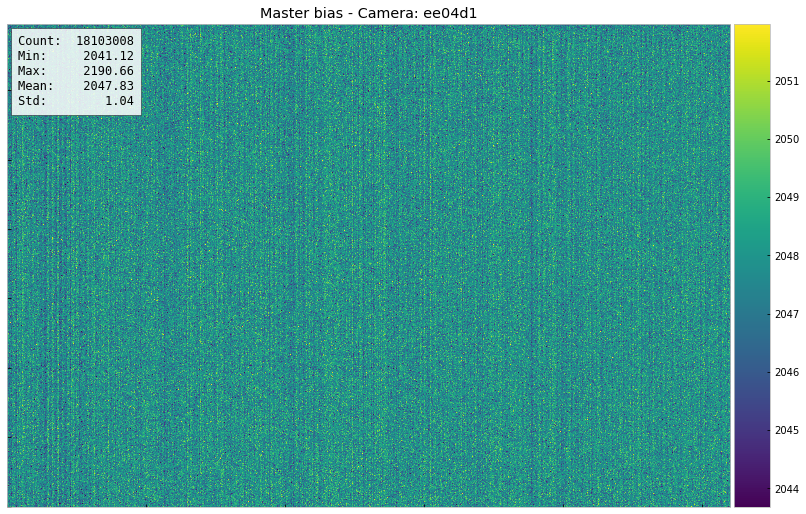

time: 2.11 s


In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.imshow(master_bias, vmax=bias_mean + 4*bias_std, vmin=bias_mean - 4*bias_std)
ax.set_title('Master bias - Camera: {}'.format(camera_id))
ax.grid(False)

ob = offsetbox.AnchoredText(bias_props, loc=2, prop=dict(size=12, family="monospace"))
ob.patch.set(boxstyle='square,pad=0.2', alpha=0.85)
fig.gca().add_artist(ob)

# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

ax.set_xticklabels([])
ax.set_yticklabels([])

fig.tight_layout()
fig.set_size_inches(fig.get_size_inches() * 2)

fig.savefig('/var/panoptes/images/pan001-{}-master-bias.png'.format(camera_id), transparent=False)

/home/wtylergee/miniconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


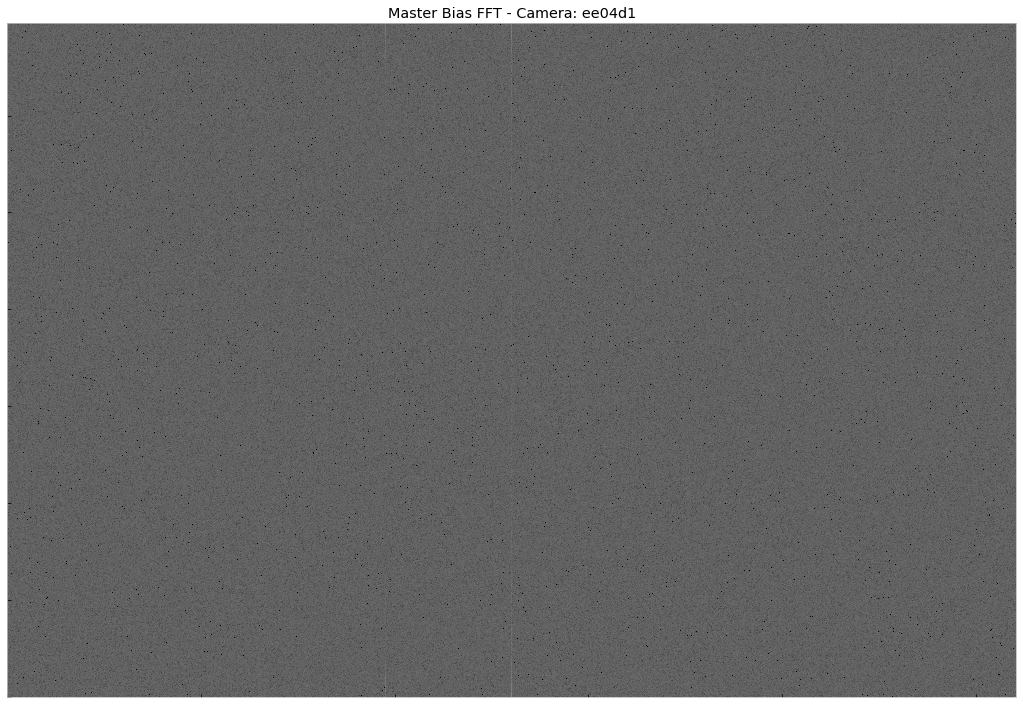

time: 6.07 s


In [96]:
# FFT
f0 = fftpack.fft2(master_bias.data)

fig = plt.figure()

ax = fig.add_subplot(111)

ax.imshow(np.abs(f0), cmap='Greys_r', norm=LogNorm())
ax.set_title('Master Bias FFT - Camera: {}'.format(camera_id))
ax.grid(False)

ax.set_xticklabels([])
ax.set_yticklabels([])

fig.tight_layout()    
fig.set_size_inches(fig.get_size_inches() * 2.7)

fig.savefig(
    '/var/panoptes/images/pan001-{}-master-bias-fft.png'.format(camera_id), 
    transparent=False
)

## Readnoise

See [Flat Frame and Gain](FlatFrameAndGain.ipynb) for gain calculations.

In [48]:
gain = 1.5 * (u.electron / u.adu)

time: 1.23 ms


In [64]:
# Readnoise in ADU
readnoise = np.array([np.array(master_bias.data - ccd.data).std() for ccd in bias_data]) * u.adu

time: 18 s


In [103]:
readnoise.mean()

<Quantity 6.9813147 adu>

time: 5.53 ms


In [65]:
# Convert to electrons
readnoise_e = readnoise * gain

time: 1.19 ms


In [66]:
read_mean = readnoise_e.mean()
read_mean

<Quantity 10.4719715 electron>

time: 4.3 ms


In [67]:
read_std = readnoise_e.std()
read_std

<Quantity 0.03945236 electron>

time: 3.39 ms


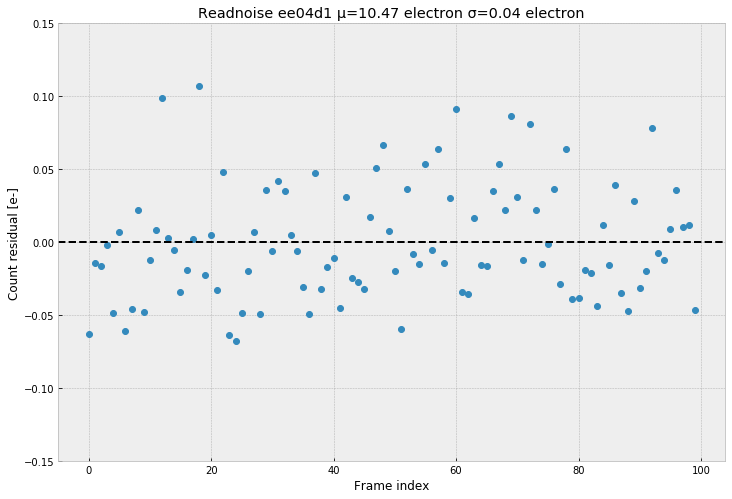

time: 489 ms


In [102]:
fig = plt.figure()

ax = fig.add_subplot(111)

read_residual = readnoise_e - read_mean

ax.plot(read_residual, ls='', marker='o')
ax.axhline(0, c='k', ls='--')

ax.set_ylim([-.15, .15])
ax.set_ylabel('Count residual [e-]')
ax.set_xlabel('Frame index')
ax.set_title('Readnoise {} μ={:.02f} σ={:.02f}'.format(camera_id, readnoise.mean() * gain, readnoise.std() * gain))

fig.tight_layout()    
fig.set_size_inches(fig.get_size_inches() * 2)

fig.savefig(
    '/var/panoptes/images/pan001-{}-readnoise-frame-hist.png'.format(camera_id), 
    transparent=False
)

In [79]:
read0 = master_bias.data - bias_data[5]

time: 75.1 ms


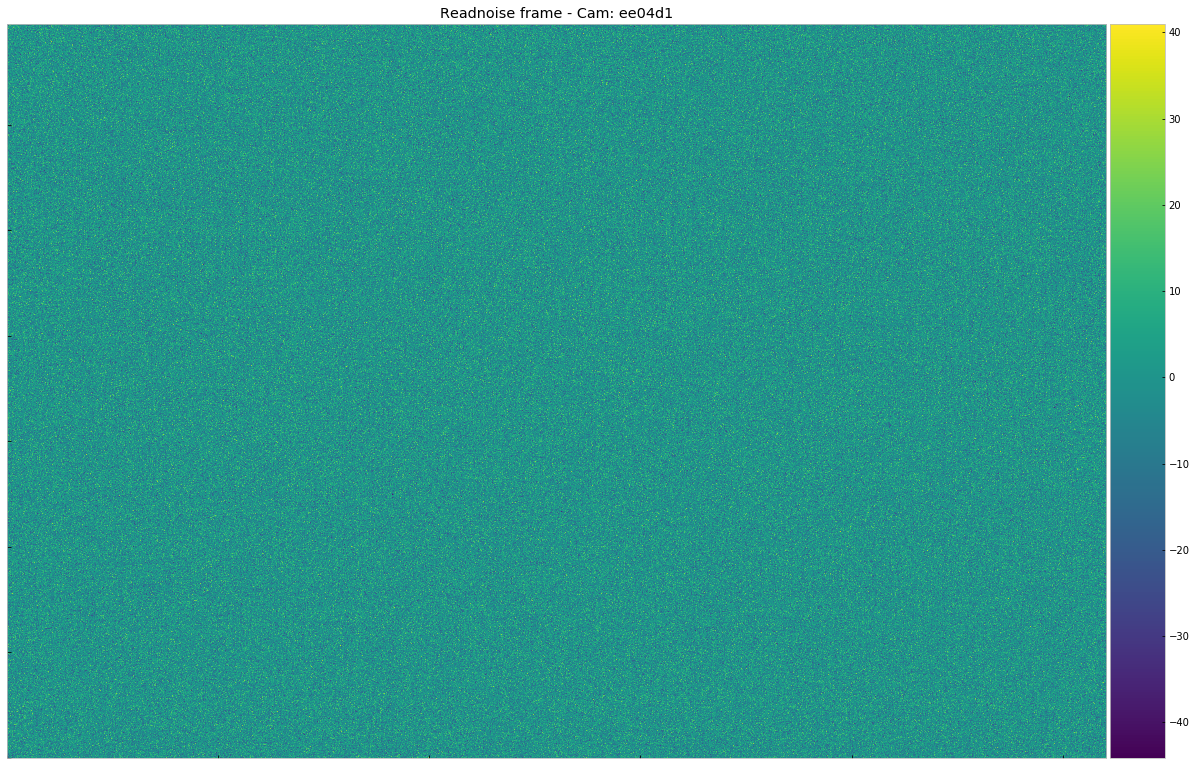

time: 3.31 s


In [80]:
fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.imshow(read0)
ax.set_title('Readnoise frame - Cam: {}'.format(camera_id))
ax.grid(False)

# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

ax.set_xticklabels([])
ax.set_yticklabels([])

fig.tight_layout()
fig.set_size_inches(fig.get_size_inches() * 3)

fig.savefig(
    '/var/panoptes/images/pan001-{}-readnoise-frame.png'.format(camera_id),
            transparent=False)

/home/wtylergee/miniconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


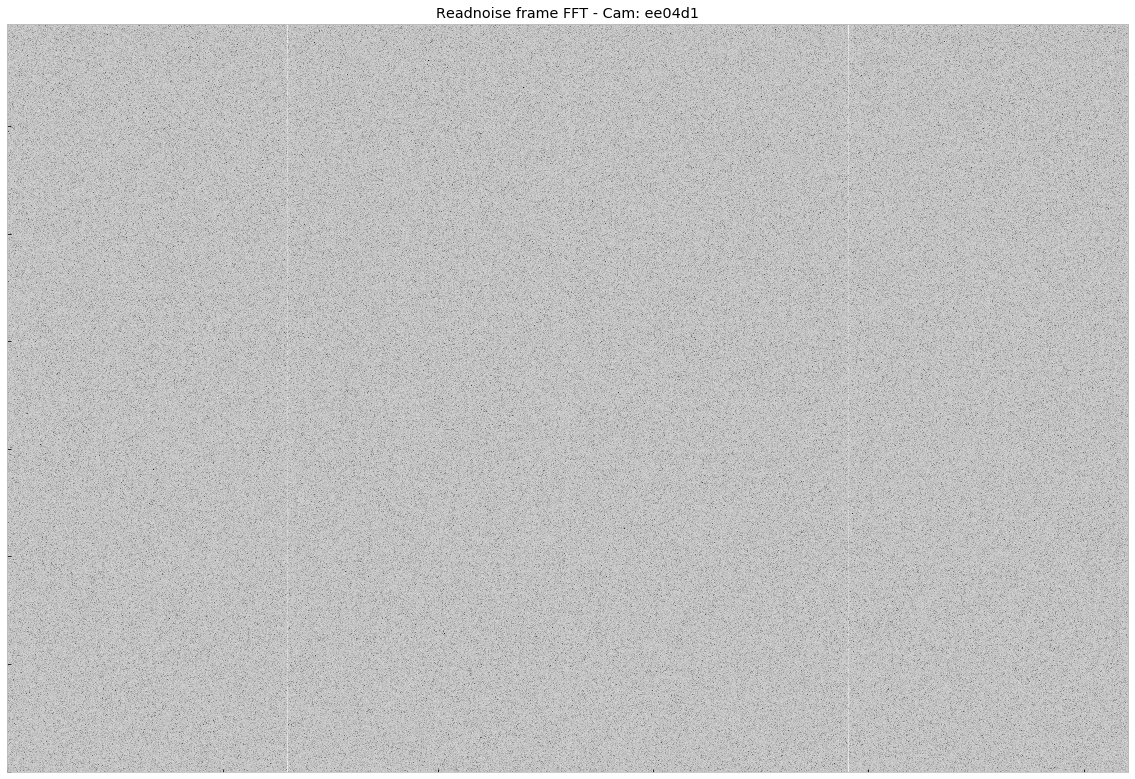

time: 7.87 s


In [82]:
# FFT
f0 = fftpack.fft2(read0)

fig = plt.figure()

ax = fig.add_subplot(111)

ax.imshow(np.abs(f0), cmap='Greys_r', norm=LogNorm())
ax.set_title('Readnoise frame FFT - Cam: {}'.format(camera_id))
ax.grid(False)

ax.set_xticklabels([])
ax.set_yticklabels([])

fig.tight_layout()    
fig.set_size_inches(fig.get_size_inches() * 3)

fig.savefig('/var/panoptes/images/pan001-{}-readnoise-frame-fft.png'.format(camera_id),
            transparent=False)